## MNIST CNN

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *

### Data

Untar the data for the MNIST dataset; save the path to `path`.

In [4]:
path = untar_data(URLs.MNIST)

Show the contents of the `path` directory.

In [5]:
path.ls()

[PosixPath('/home/paperspace/.fastai/data/mnist_png/testing'),
 PosixPath('/home/paperspace/.fastai/data/mnist_png/training'),
 PosixPath('/home/paperspace/.fastai/data/mnist_png/models')]

Create an `ImageList` from the folder `path`. Set `convert_mode` to `L`. Save it to variable `il`. What does this do?

In [6]:
il = ImageList.from_folder(path, convert_mode='L')

Show the first element in the `items` attribute in `il`.

In [7]:
il.items[0]

PosixPath('/home/paperspace/.fastai/data/mnist_png/testing/6/4239.png')

Set `defaults.cmap` to `'binary'`. What does this do?

In [13]:
# cmap is the colormap to use when plotting.
# when set to binary, it prints stuff out in black and white. 
defaults.cmap='binary'

Take a look at `il`.

In [10]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/paperspace/.fastai/data/mnist_png

Show the image in the first element of `il`. What's the difference in `il[0]` and `il.items[0]`?

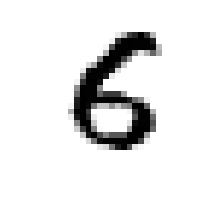

In [12]:
# the .items property is the list of filenames. indexing into the 
# image directly actually opens the image.
il[0].show()

Split the imagelist by folder with training folder `training` and validation folder `testing`. Save to variable `sd`. 

In [14]:
sd = il.split_by_folder(train='training', valid='testing')

Show `sd`.

In [15]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/paperspace/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/paperspace/.fastai/data/mnist_png;

Test: None

Show the contents of `path/'training'`.

In [17]:
(path/'training').ls()

[PosixPath('/home/paperspace/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/paperspace/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/paperspace/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/paperspace/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/paperspace/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/paperspace/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/paperspace/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/paperspace/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/paperspace/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/paperspace/.fastai/data/mnist_png/training/9')]

Label the examples from the folder they're in, and save the resulting `LabelLists` to `ll`.

In [18]:
ll = sd.label_from_folder()

Show `ll`.

In [19]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /home/paperspace/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /home/paperspace/.fastai/data/mnist_png;

Test: None

In [18]:
x,y = ll.train[0]

6 torch.Size([1, 28, 28])


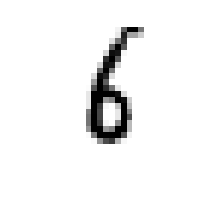

In [19]:
x.show()
print(y,x.shape)

In [20]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [21]:
ll = ll.transform(tfms)

In [22]:
bs = 128

In [23]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [24]:
x,y = data.train_ds[0]

6


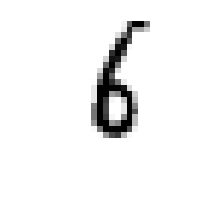

In [25]:
x.show()
print(y)

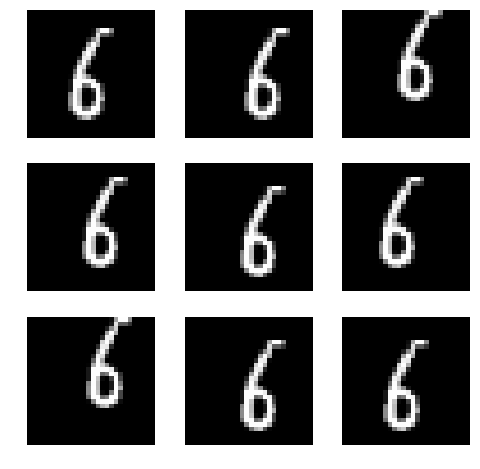

In [26]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [27]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

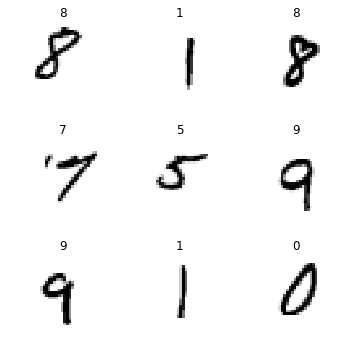

In [28]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [29]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [30]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [31]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [32]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
______________________________________________________________

In [33]:
xb = xb.cuda()

In [34]:
model(xb).shape

torch.Size([128, 10])

In [35]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


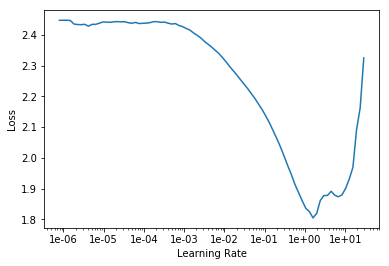

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.226870,0.148209,0.951700,00:06
1,0.131507,0.096002,0.969200,00:06
2,0.065555,0.040916,0.986700,00:06


### Refactor

In [52]:
doc(conv_layer)

In [38]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [54]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [55]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [56]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [16, 7, 7]           1,152      True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
Conv2d               [32, 4, 4]           4,608      True      
______________________________________________________________

In [41]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.249668,0.244403,0.925300,00:06
1,0.199711,0.132147,0.955200,00:06
2,0.175526,0.133379,0.957300,00:06
3,0.143081,0.112336,0.964100,00:06
4,0.114396,0.089427,0.972700,00:06
5,0.110157,0.134818,0.959000,00:06
6,0.085652,0.049076,0.984400,00:06
7,0.075929,0.041539,0.985800,00:06
8,0.054456,0.031509,0.989700,00:06
9,0.047840,0.029913,0.990000,00:06


### Resnet-ish

In [42]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [50]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [51]:
doc(res_block)

In [44]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [63]:
doc(res_block)

In [45]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [60]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [61]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [62]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


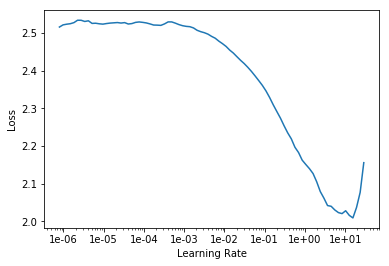

In [48]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.239462,0.147293,0.960100,00:09
1,0.129276,0.124540,0.962200,00:09
2,0.102527,0.118418,0.965100,00:09
3,0.083226,0.093571,0.972400,00:09
4,0.067582,0.072308,0.976500,00:09
5,0.063371,0.051599,0.984400,00:08
6,0.055439,0.059813,0.980800,00:09
7,0.049826,0.031558,0.990100,00:09
8,0.033731,0.023663,0.992100,00:09
9,0.025412,0.018348,0.993500,00:09


In [64]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________

## fin